In [1]:
import cv2
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Pre-processing

In [3]:
def grayScaleConversion(path):
    dict1 = {}
    dict2 = {}
    classes = os.listdir(path)
    for classe in classes:
        pathFile = path + '/' + classe
        images = os.listdir(pathFile)
        for i in range(len(images)):
            img = cv2.imread(pathFile +'/' + images[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            R, G, B = img[:,:,0], img[:,:,1],img[:,:,2]
            imgGray = 0.299 * R + 0.587 * G + 0.114 * B
            if classe == 'benign':
                dict1[pathFile+ '/' + images[i]] = imgGray
            else:
                dict2[pathFile+ '/' + images[i]] = imgGray       
    return dict1,dict2        

In [4]:
def noiseRemoval(dict1, dict2):
    for key,value in dict1.items() :
        newimg = cv2.medianBlur(value, 1)
        dict1[key] = newimg
    for key,value in dict2.items() :
        newimg = cv2.medianBlur(value, 1)
        dict2[key] = newimg 
    return dict1, dict2

In [5]:
def imageEnhancement(dict1, dict2):
    for key,value in dict1.items() :
        value = np.uint8(cv2.normalize(value, None, 0, 255, cv2.NORM_MINMAX))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        #gray_img_eqhist=cv2.equalizeHist(value)
        value=clahe.apply(value)
        dict1[key] = value
    for key,value in dict2.items() :
        value = np.uint8(cv2.normalize(value, None, 0, 255, cv2.NORM_MINMAX))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        #gray_img_eqhist=cv2.equalizeHist(value)
        value=clahe.apply(value)
        dict2[key] = value
    return dict1, dict2

In [6]:
path_train = 'data/train'

In [7]:
images = os.listdir(path_train)
print(images)
for i in images:
    print (i)

['benign', 'malignant']
benign
malignant


In [8]:
dict1, dict2 = grayScaleConversion(path_train)

In [9]:
len(dict1)

1440

In [10]:
img1= dict1['data/train/benign/100.jpg']

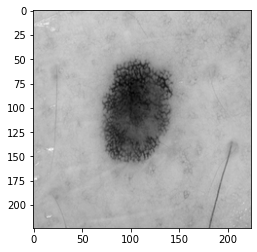

In [11]:
plt.imshow(img1, cmap='gray')

In [12]:
dict1, dict2 = noiseRemoval(dict1, dict2)

In [13]:
dict1

{'data/train/benign/100.jpg': array([[191.105, 192.008, 192.236, ..., 172.63 , 169.63 , 169.103],
        [188.8  , 190.849, 188.333, ..., 169.103, 171.63 , 173.325],
        [190.817, 193.86 , 190.105, ..., 172.63 , 174.146, 172.63 ],
        ...,
        [165.27 , 169.096, 166.965, ..., 158.793, 162.135, 163.531],
        [163.993, 165.993, 165.737, ..., 158.787, 163.836, 164.531],
        [163.993, 164.047, 164.737, ..., 156.195, 158.776, 161.531]]),
 'data/train/benign/1000.jpg': array([[148.99 , 149.762, 150.762, ..., 148.213, 150.68 , 147.919],
        [150.235, 147.762, 149.958, ..., 149.968, 150.136, 149.196],
        [147.702, 148.99 , 148.958, ..., 154.261, 150.147, 147.826],
        ...,
        [131.957, 132.729, 136.946, ..., 142.017, 140.963, 140.322],
        [128.245, 130.017, 131.74 , ..., 138.322, 135.202, 136.262],
        [129.729, 133.017, 132.985, ..., 136.034, 134.806, 137.877]]),
 'data/train/benign/1001.jpg': array([[153.886, 155.163, 160.864, ..., 147.163, 150

In [13]:
img2  = dict1['data/train/benign/100.jpg']

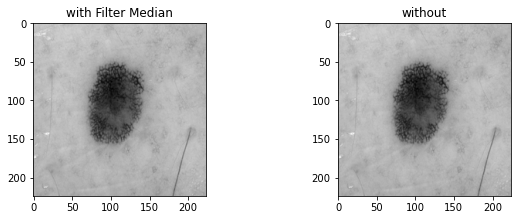

In [14]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.title("with Filter Median")
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 2, 2)
plt.title("without")
plt.imshow(img1, cmap='gray')

In [15]:
dict1, dict2 = imageEnhancement(dict1, dict2)

In [16]:
img3  = dict1['data/train/benign/100.jpg']

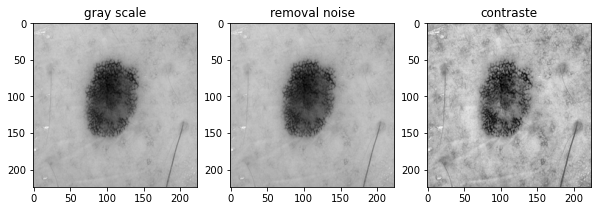

In [17]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 3, 1)
plt.title("gray scale")
plt.imshow(img1, cmap='gray')
fig.add_subplot(2, 3, 2)
plt.title("removal noise")
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 3, 3)
plt.title("contraste")
plt.imshow(img3, cmap='gray')

## Segmentation

In [18]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import threshold_otsu

In [19]:
def segment(img):
    """
    Maximum entropy segmentation
    :param img:
    :return:
    """
    def calculate_current_entropy(hist, threshold):
        data_hist = hist.copy()
        background_sum = 0.
        target_sum = 0.
        for i in range(256):
            if i < threshold:  #
                background_sum += data_hist[i]
            else:  #
                target_sum += data_hist[i]
        background_ent = 0.
        target_ent = 0.
        for i in range(256):
            if i < threshold:  # Calculate background entropy
                if data_hist[i] == 0:
                    continue
                ratio1 = data_hist[i] / background_sum
                background_ent -= ratio1 * np.log2(ratio1)
            else:
                if data_hist[i] == 0:
                    continue
                ratio2 = data_hist[i] / target_sum
                target_ent -= ratio2 * np.log2(ratio2)
        return target_ent + background_ent
    def max_entropy_segmentation(img):
            channels = [0]
            hist_size = [256]
            prange = [0, 256]
            hist = cv2.calcHist(img, channels, None, hist_size, prange)
            hist = np.reshape(hist, [-1])
            max_ent = 0.
            max_index = 0
            for i in range(256):
                cur_ent = calculate_current_entropy(hist, i)
                if cur_ent > max_ent:
                    max_ent = cur_ent
                    max_index = i
            ret, th = cv2.threshold(img, max_index, 255, cv2.THRESH_BINARY)
            return th
    img = max_entropy_segmentation(img)
    return img

In [20]:
def segmentation(dict1, dict2):
    for key,value in dict1.items() :
        newValue = segment(value)
        dict1[key] = newValue
    for key, value in dict2.items():
        newValue = segment(value)
        dict2[key] = newValue
    return dict1, dict2    

In [21]:
dict1, dict2 = segmentation(dict1, dict2)

In [22]:
img4 = dict1['data/train/benign/100.jpg']

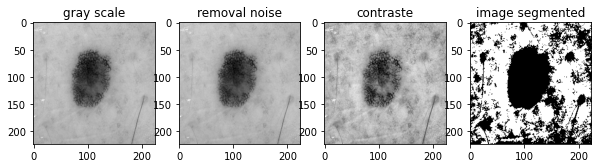

In [23]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 4, 1)
plt.title("gray scale")
plt.imshow(img1, cmap='gray')
fig.add_subplot(2, 4, 2)
plt.title("removal noise")
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 4, 3)
plt.title("contraste")
plt.imshow(img3, cmap='gray')
fig.add_subplot(2, 4, 4)
plt.title("image segmented")
plt.imshow(img4, cmap='gray')

## Features Extraction

### GLCM ( gray-level co-occurrence matrix )

In [24]:
import pandas as pd
import matplotlib.pyplot as pltHomogeneity
from skimage.feature import greycomatrix, greycoprops

In [25]:
def GLCM(img):
    GLCM = greycomatrix(img,[1],[0,np.pi/4,np.pi/2,3*np.pi/4])
    Contrast = greycoprops(GLCM,'contrast')[0,0]
    ASM = greycoprops(GLCM,'ASM')[0,0]
    Energy = greycoprops(GLCM,'energy')[0,0]
    Homogeneity = greycoprops(GLCM,'homogeneity')[0,0]
    correlation = greycoprops(GLCM,'correlation')[0,0]
    return Contrast, ASM, Energy, Homogeneity, correlation

In [26]:
Contrast, ASM, Energy, Homogeneity, correlation = GLCM(img4)

In [27]:
Contrast

9537.919903106984

In [28]:
ASM

0.38663844308473355

In [29]:
Energy

0.6218025756498067

In [30]:
correlation

0.6995461486011325

In [31]:
Homogeneity

0.8533214421445732

In [32]:
def featuresExtraction(dict1, dict2):
    df=pd.DataFrame(columns=['Contrast','ASM','Energy','Homogeneity','correlation','outcome'])
    for key, value in dict1.items():
        Contrast, ASM, Energy, Homogeneity, correlation = GLCM(value)
        df.loc[len(df.index)] = [Contrast, ASM, Energy, Homogeneity, correlation, 'begnin']
    for key, value in dict2.items():
        Contrast, ASM, Energy, Homogeneity, correlation = GLCM(value)
        df.loc[len(df.index)] = [Contrast, ASM, Energy, Homogeneity, correlation, 'malignant']
    return df  

In [33]:
df = featuresExtraction(dict1, dict2)

In [34]:
df.shape

(2637, 6)

In [35]:
df.tail(20)

,Contrast,ASM,Energy,Homogeneity,correlation,outcome
2617,7785.764834,0.401568,0.633694,0.880267,0.757159,malignant
2618,7465.534413,0.402151,0.634154,0.885192,0.768632,malignant
2619,6044.023763,0.424385,0.651448,0.907052,0.810812,malignant
2620,7159.623238,0.440892,0.663997,0.889896,0.761231,malignant
2621,8327.292701,0.409542,0.639955,0.871939,0.732531,malignant
2622,4412.931414,0.523336,0.723420,0.932136,0.835847,malignant
2623,6387.685678,0.420195,0.648224,0.901767,0.800020,malignant
2624,4925.820788,0.471149,0.686403,0.924248,0.834918,malignant
2625,5016.943266,0.482274,0.694460,0.922847,0.827212,malignant
2626,7508.492152,0.460315,0.678465,0.884531,0.736095,malignant


In [36]:
df.to_csv('features_train_KC.csv')

## Classification

In [37]:
from sklearn.svm import SVC

In [38]:
from sklearn.svm import LinearSVC

In [39]:
y = df['outcome'].map({"begnin":0,"malignant":1})

In [40]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2632    1
2633    1
2634    1
2635    1
2636    1
Name: outcome, Length: 2637, dtype: int64

In [41]:
df = df.drop(['outcome'], axis=1)

In [42]:
x = df

In [43]:
x

,Contrast,ASM,Energy,Homogeneity,correlation
0,9537.919903,0.386638,0.621803,0.853321,0.699546
1,10520.740911,0.442719,0.665371,0.838207,0.616293
2,8665.747618,0.623817,0.789821,0.866734,0.488761
3,5113.272742,0.468113,0.684188,0.921366,0.828843
4,5926.866292,0.617092,0.785552,0.908854,0.696248
...,...,...,...,...,...
2632,7711.565102,0.405549,0.636828,0.881408,0.757933
2633,5309.836943,0.550544,0.741986,0.918343,0.781953
2634,3909.154288,0.733234,0.856291,0.939883,0.714101
2635,7025.543021,0.405036,0.636425,0.891958,0.783304


In [47]:
svclassifier = SVC(kernel = 'rbf')
model = svclassifier.fit(x, y)

In [53]:
LSVM = LinearSVC(penalty='l1', loss='squared_hinge', C=1.0, dual=False)
model2 = LSVM.fit(x, y)

## Test data

In [48]:
path_test = 'data/test'

## Pre-processing

In [49]:
dict_test1, dict_test2 = grayScaleConversion(path_test)

In [50]:
dict_test1, dict_test2 = noiseRemoval(dict_test1, dict_test2)

In [51]:
dict_test1, dict_test2 = imageEnhancement(dict_test1, dict_test2)

## Sigmentation

In [52]:
dict_test1, dict_test2 = segmentation(dict_test1, dict_test2)

## Features Extraction

In [54]:
df_test = featuresExtraction(dict_test1, dict_test2)

In [55]:
df_test.head(20)

,Contrast,ASM,Energy,Homogeneity,correlation,outcome
0,680.815082,0.865357,0.930245,0.989530,0.915793,begnin
1,5371.019178,0.634475,0.796540,0.917402,0.714928,begnin
2,2560.541620,0.462279,0.679911,0.960623,0.921229,begnin
3,9509.281410,0.390171,0.624636,0.853762,0.698459,begnin
4,7461.629164,0.585657,0.765282,0.885252,0.633105,begnin
5,11344.748459,0.465591,0.682342,0.825535,0.553084,begnin
6,10037.791780,0.403897,0.635529,0.845634,0.668428,begnin
7,6724.838845,0.674682,0.821391,0.896582,0.555434,begnin
8,3132.009729,0.637011,0.798130,0.951835,0.848142,begnin
9,11398.120195,0.479938,0.692776,0.824714,0.533191,begnin


In [56]:
df_test.tail(20)

,Contrast,ASM,Energy,Homogeneity,correlation,outcome
640,6258.812460,0.491428,0.701019,0.903749,0.771689,malignant
641,9566.558396,0.414947,0.644163,0.852881,0.679879,malignant
642,5916.452294,0.481978,0.694246,0.909014,0.790985,malignant
643,7345.773443,0.415435,0.644543,0.887033,0.766768,malignant
644,6905.782051,0.408999,0.639530,0.893800,0.785925,malignant
645,6498.334401,0.472024,0.687040,0.900066,0.771850,malignant
646,6950.041540,0.454218,0.673957,0.893119,0.762654,malignant
647,4574.348374,0.472136,0.687122,0.929654,0.847892,malignant
648,4825.586063,0.533691,0.730542,0.925790,0.813364,malignant
649,5619.653367,0.448936,0.670027,0.913578,0.816956,malignant


In [57]:
df_test.to_csv('features_test_KC.csv')

## Prediction

In [58]:
y_test = df_test['outcome'].map({"begnin":0,"malignant":1})
df_test = df_test.drop(['outcome'], axis=1)
x_test =  df_test

In [59]:
y_predict = model2.predict(x_test)

In [60]:
y_predict

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [61]:
y_test = np.asarray(y_test)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [62]:
accuracy = model2.score(x_test,y_test)

In [63]:
accuracy

0.6954545454545454